# Comparision of Trained Models

After training our models with different parameters, we obtained four models. Two of them use the Autoregressive Input, each with a different loss function: CustomLoss and SmoothL1Loss. The other two models do not use the autoregressive functionality but instead use a simple repeat. These were also tested with the two different loss functions mentioned above.



In [7]:
from PredictionModel.RetrievalAugmentedPredictionModel import RetrievalAugmentedPredictionModel
from RetrievalSystem.RetrievalSystem import RetrievalSystem
import torch
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Load in the standard parameters for the comparison

# Initialize the model - HAVE TO BE ADAPTED TO DATASET (Values are likely correct)
forecast_steps_num = 12       # Predict next 12 months
retrieval_num = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
retrieval_system = RetrievalSystem("../RetrievalSystem/Embeddings/embeddings.csv", retrieval_number=retrieval_num)

# Load in the Dataset
DATASET_PATH = "../Dataset/Data/normalized_real_company_stock_dataset_large.csv"
dataset = pd.read_csv(DATASET_PATH)

# Load in the scaler
historical_scaler = joblib.load('../Dataset/Data/Scaler/historical_scaler.pkl')

#### Functions to plot the predictions

In [9]:
def plot_single_function(function):
    plt.figure(figsize=(12, 8))
    plt.plot(function[0], linestyle='-', color='blue')
    plt.xlabel('Months')
    plt.ylabel('Stock-Value')
    plt.title('Stock Performance')
    plt.grid(True)
    plt.show()

def plot_comparison_function(prediction_function, target_function):
    prediction_function = np.insert(prediction_function[0], 0, target_function[0][59])
    x_values = np.arange(59, 72)
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, prediction_function, linestyle='-', color='red', label='Predictions')
    plt.plot(target_function[0], linestyle='-', color='blue', label='Target Function')
    plt.xlabel('Months')
    plt.ylabel('Stock-Value')
    plt.title('Predictions vs. Target Stock Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_comparison_function4(func1, func2, func3, func4, func5):
    plt.figure(figsize=(12, 8))
    plt.plot(func1[0], linestyle='-', color='blue', label='AUX + CustomLoss (10 E)')
    plt.plot(func2[0], linestyle='-', color='red', label='AUX + SmoothL1Loss')
    plt.plot(func3[0], linestyle='-', color='green', label='No-AUX + CustomLoss')
    plt.plot(func4[0], linestyle='-', color='orange', label='No-AUX + SmoothL1Loss')
    plt.plot(func5[0], linestyle='-', color='yellow', label='AUX + CustomLoss (20 E)')
    plt.xlabel('Months')
    plt.ylabel('Stock-Value')
    plt.title('Predictions vs. Target Stock Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


## Comparison with known Data

At first we compare the model with already known Data, to see how accurate it is.

### Model with Autoregressive Input enabled + CustomLoss ( 10 Epochs )

Retrieved tickers:  [array(['A', 'NSTG', 'TECH', 'MLAB', 'LAB', 'BRKR', 'RPID', 'WAT', 'TWST',
       'TMO'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_out

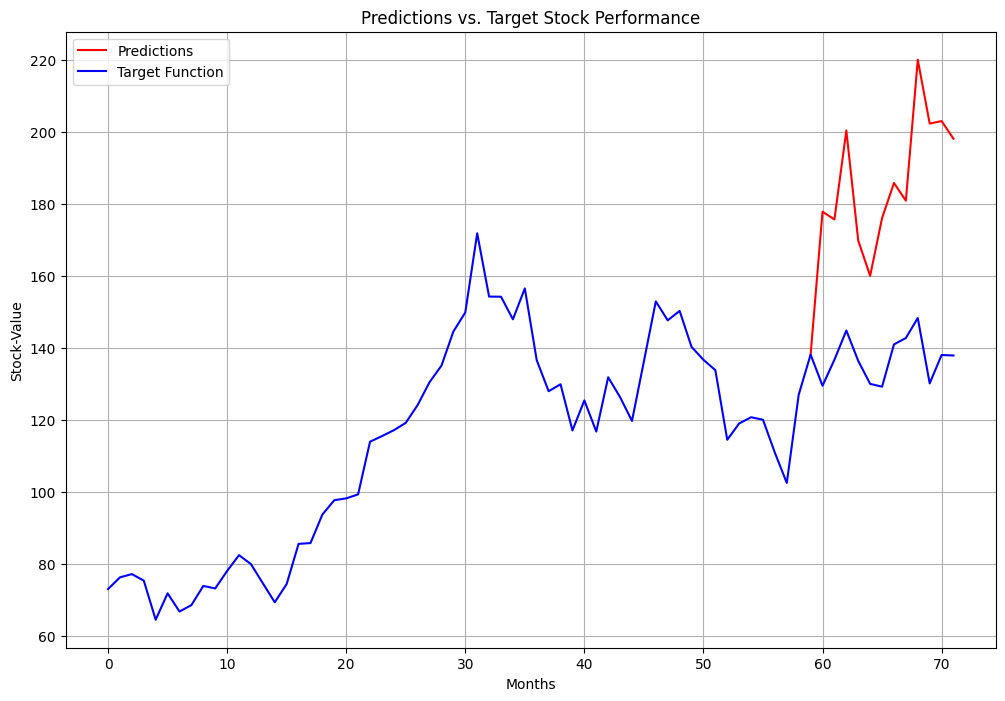

In [10]:
# Path to the used RAPModel
model_aux_customloss = "./RAPModel/trained_model_aux-true_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_np = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_np)

# Prepare the comparison Date
target = [4.692009405211874e-06, 5.466743387201781e-06, 5.812687703220634e-06, 5.927919220900933e-06, 7.275632459163935e-06,6.985509247783324e-06, 8.063849849977355e-06, 6.360893276057977e-06, 7.184651099125486e-06,7.875696920662246e-06, 8.84750002906436e-06, 1.1411723516192887e-05, 1.1101770401000976e-05, 1.0944987829674895e-05, 1.6658468160543358e-05, 1.5032200668797349e-05, 1.7603364795323754e-05, 4.376864223429129e-06, 2.8367622599542556e-06, 6.498769022826742e-06, 4.853902082922962e-06, 7.505735482398254e-06, 4.944066206614177e-06, 3.6785550803029167e-06, 4.133710860364404e-06, 5.1510673552635585e-06, 5.050576582253829e-06, 5.094194849867579e-06, 5.809375015756091e-06, 4.970303572532357e-06, 5.479099463806013e-06, 6.977465170659404e-06, 8.31664660473343e-06, 7.3747864609029275e-06, 8.298825521929363e-06, 1.3295962234604047e-05, 1.884561542645251e-05, 3.364200830302844e-05, 1.9367176485452787e-05, 3.9407739093408034e-05, 3.980081951807416e-05, 5.086419265514365e-05, 7.414932787502197e-05, 8.37638639889744e-05, 0.0001295208373627105, 0.000126128175523546, 0.0003575585080866228, 0.00022620583019037358, 0.0001963656556372549, 0.0002709824124396135, 0.00046717195429353634, 0.000580613480673896, 0.0009214269788560851, 0.0011595767283300211, 0.0010815993688439811, 0.0014036561843247444, 0.0012193992455275804, 0.0025188592331247695, 0.01061036614338507, 0.01312552014182201, 0.01503394965372296, 0.017354364304315476, 0.016453505944279002, 0.018329071288595525, 0.016920466273811382, 0.01702354838900635, 0.01637107714832892, 0.015556659956418879, 0.015108747247887811, 0.01421452874730981, 0.014938964315570494, 0.015393059843423014]
target_tensor = torch.tensor(target, device=predictions.device)
target_tensor = target_tensor.unsqueeze(0)

# Denormalize the target data
norm_target_np = target_tensor.cpu().detach().numpy()
denorm_target_np = historical_scaler.inverse_transform(norm_target_np)

# Plot the data
# plot_single_function(denorm_predictions_np)
# plot_single_function(denorm_target_np)
plot_comparison_function(denorm_predictions_np, denorm_target_np)


### Model with Autoregressive Input enabled + CustomLoss ( 20 Epochs )

Retrieved tickers:  [array(['A', 'NSTG', 'TECH', 'MLAB', 'LAB', 'BRKR', 'RPID', 'WAT', 'TWST',
       'TMO'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_out

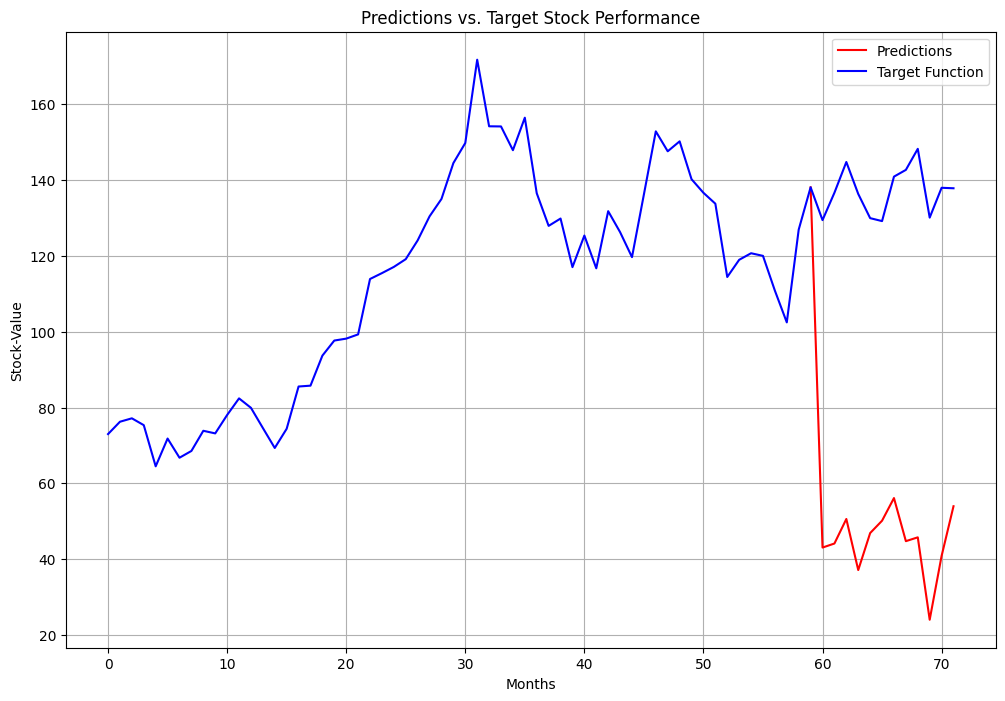

In [11]:
# Path to the used RAPModel
model_aux_customloss_20E = "./RAPModel/trained_model_aux-true_CustomLoss_20E.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss_20E, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_np_20E = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_np_20E)

# Prepare the comparison Date
target = [4.692009405211874e-06, 5.466743387201781e-06, 5.812687703220634e-06, 5.927919220900933e-06, 7.275632459163935e-06,6.985509247783324e-06, 8.063849849977355e-06, 6.360893276057977e-06, 7.184651099125486e-06,7.875696920662246e-06, 8.84750002906436e-06, 1.1411723516192887e-05, 1.1101770401000976e-05, 1.0944987829674895e-05, 1.6658468160543358e-05, 1.5032200668797349e-05, 1.7603364795323754e-05, 4.376864223429129e-06, 2.8367622599542556e-06, 6.498769022826742e-06, 4.853902082922962e-06, 7.505735482398254e-06, 4.944066206614177e-06, 3.6785550803029167e-06, 4.133710860364404e-06, 5.1510673552635585e-06, 5.050576582253829e-06, 5.094194849867579e-06, 5.809375015756091e-06, 4.970303572532357e-06, 5.479099463806013e-06, 6.977465170659404e-06, 8.31664660473343e-06, 7.3747864609029275e-06, 8.298825521929363e-06, 1.3295962234604047e-05, 1.884561542645251e-05, 3.364200830302844e-05, 1.9367176485452787e-05, 3.9407739093408034e-05, 3.980081951807416e-05, 5.086419265514365e-05, 7.414932787502197e-05, 8.37638639889744e-05, 0.0001295208373627105, 0.000126128175523546, 0.0003575585080866228, 0.00022620583019037358, 0.0001963656556372549, 0.0002709824124396135, 0.00046717195429353634, 0.000580613480673896, 0.0009214269788560851, 0.0011595767283300211, 0.0010815993688439811, 0.0014036561843247444, 0.0012193992455275804, 0.0025188592331247695, 0.01061036614338507, 0.01312552014182201, 0.01503394965372296, 0.017354364304315476, 0.016453505944279002, 0.018329071288595525, 0.016920466273811382, 0.01702354838900635, 0.01637107714832892, 0.015556659956418879, 0.015108747247887811, 0.01421452874730981, 0.014938964315570494, 0.015393059843423014]
target_tensor = torch.tensor(target, device=predictions.device)
target_tensor = target_tensor.unsqueeze(0)

# Denormalize the target data
norm_target_np = target_tensor.cpu().detach().numpy()
denorm_target_np = historical_scaler.inverse_transform(norm_target_np)

# Plot the data
# plot_single_function(denorm_predictions_np)
# plot_single_function(denorm_target_np)
plot_comparison_function(denorm_predictions_np_20E, denorm_target_np)

### Model with Autoregressive Input enabled + SmoothL1Loss

Retrieved tickers:  [array(['A', 'NSTG', 'TECH', 'MLAB', 'LAB', 'BRKR', 'RPID', 'WAT', 'TWST',
       'TMO'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_out

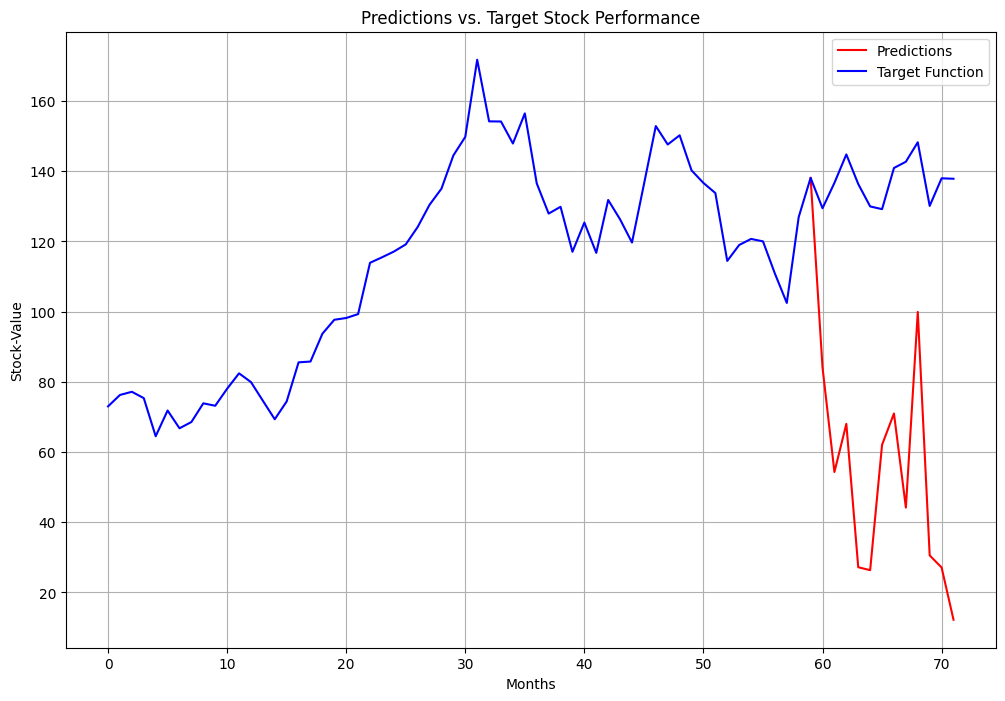

In [12]:
# Path to the used RAPModel
model_aux_smoothL1loss = "./RAPModel/trained_model_aux-true_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_np = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_np)

# Prepare the comparison Date
target = [4.692009405211874e-06, 5.466743387201781e-06, 5.812687703220634e-06, 5.927919220900933e-06, 7.275632459163935e-06,6.985509247783324e-06, 8.063849849977355e-06, 6.360893276057977e-06, 7.184651099125486e-06,7.875696920662246e-06, 8.84750002906436e-06, 1.1411723516192887e-05, 1.1101770401000976e-05, 1.0944987829674895e-05, 1.6658468160543358e-05, 1.5032200668797349e-05, 1.7603364795323754e-05, 4.376864223429129e-06, 2.8367622599542556e-06, 6.498769022826742e-06, 4.853902082922962e-06, 7.505735482398254e-06, 4.944066206614177e-06, 3.6785550803029167e-06, 4.133710860364404e-06, 5.1510673552635585e-06, 5.050576582253829e-06, 5.094194849867579e-06, 5.809375015756091e-06, 4.970303572532357e-06, 5.479099463806013e-06, 6.977465170659404e-06, 8.31664660473343e-06, 7.3747864609029275e-06, 8.298825521929363e-06, 1.3295962234604047e-05, 1.884561542645251e-05, 3.364200830302844e-05, 1.9367176485452787e-05, 3.9407739093408034e-05, 3.980081951807416e-05, 5.086419265514365e-05, 7.414932787502197e-05, 8.37638639889744e-05, 0.0001295208373627105, 0.000126128175523546, 0.0003575585080866228, 0.00022620583019037358, 0.0001963656556372549, 0.0002709824124396135, 0.00046717195429353634, 0.000580613480673896, 0.0009214269788560851, 0.0011595767283300211, 0.0010815993688439811, 0.0014036561843247444, 0.0012193992455275804, 0.0025188592331247695, 0.01061036614338507, 0.01312552014182201, 0.01503394965372296, 0.017354364304315476, 0.016453505944279002, 0.018329071288595525, 0.016920466273811382, 0.01702354838900635, 0.01637107714832892, 0.015556659956418879, 0.015108747247887811, 0.01421452874730981, 0.014938964315570494, 0.015393059843423014]
target_tensor = torch.tensor(target, device=predictions.device)
target_tensor = target_tensor.unsqueeze(0)

# Denormalize the target data
norm_target_np = target_tensor.cpu().detach().numpy()
denorm_target_np = historical_scaler.inverse_transform(norm_target_np)

# Plot the data
# plot_single_function(denorm_predictions_np)
# plot_single_function(denorm_target_np)
plot_comparison_function(denorm_predictions_np, denorm_target_np)

### Model with Autoregressive Input disabled + CustomLoss

Retrieved tickers:  [array(['A', 'NSTG', 'TECH', 'MLAB', 'LAB', 'BRKR', 'RPID', 'WAT', 'TWST',
       'TMO'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_out

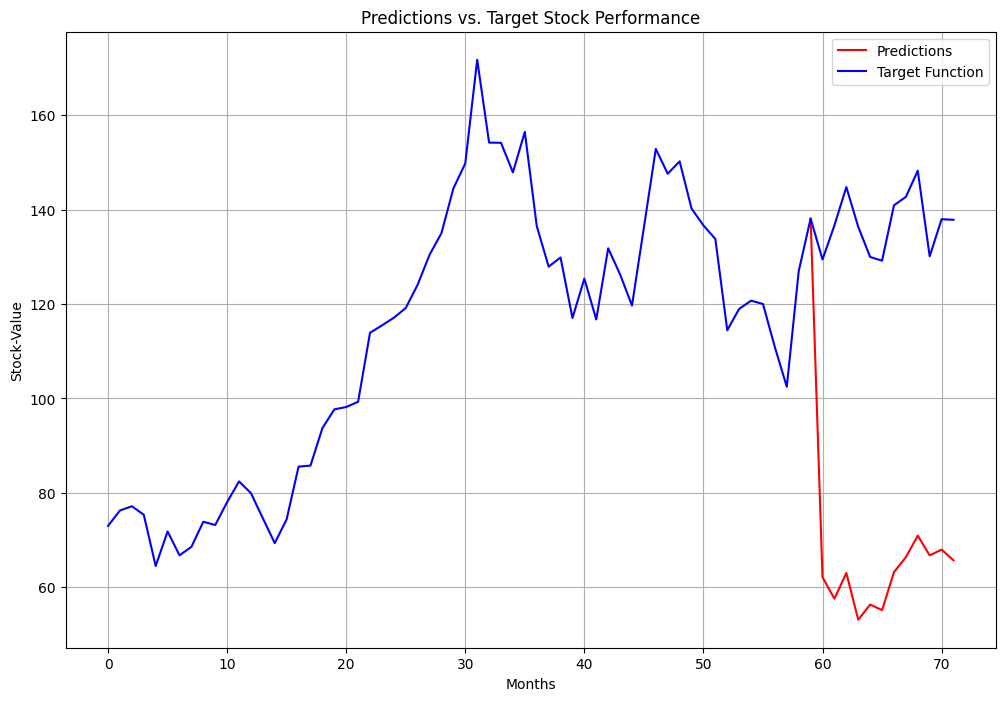

In [13]:
# Path to the used RAPModel
model_customloss = "./RAPModel/trained_model_aux-false_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_np = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_np)

# Prepare the comparison Date
target = [4.692009405211874e-06, 5.466743387201781e-06, 5.812687703220634e-06, 5.927919220900933e-06, 7.275632459163935e-06,6.985509247783324e-06, 8.063849849977355e-06, 6.360893276057977e-06, 7.184651099125486e-06,7.875696920662246e-06, 8.84750002906436e-06, 1.1411723516192887e-05, 1.1101770401000976e-05, 1.0944987829674895e-05, 1.6658468160543358e-05, 1.5032200668797349e-05, 1.7603364795323754e-05, 4.376864223429129e-06, 2.8367622599542556e-06, 6.498769022826742e-06, 4.853902082922962e-06, 7.505735482398254e-06, 4.944066206614177e-06, 3.6785550803029167e-06, 4.133710860364404e-06, 5.1510673552635585e-06, 5.050576582253829e-06, 5.094194849867579e-06, 5.809375015756091e-06, 4.970303572532357e-06, 5.479099463806013e-06, 6.977465170659404e-06, 8.31664660473343e-06, 7.3747864609029275e-06, 8.298825521929363e-06, 1.3295962234604047e-05, 1.884561542645251e-05, 3.364200830302844e-05, 1.9367176485452787e-05, 3.9407739093408034e-05, 3.980081951807416e-05, 5.086419265514365e-05, 7.414932787502197e-05, 8.37638639889744e-05, 0.0001295208373627105, 0.000126128175523546, 0.0003575585080866228, 0.00022620583019037358, 0.0001963656556372549, 0.0002709824124396135, 0.00046717195429353634, 0.000580613480673896, 0.0009214269788560851, 0.0011595767283300211, 0.0010815993688439811, 0.0014036561843247444, 0.0012193992455275804, 0.0025188592331247695, 0.01061036614338507, 0.01312552014182201, 0.01503394965372296, 0.017354364304315476, 0.016453505944279002, 0.018329071288595525, 0.016920466273811382, 0.01702354838900635, 0.01637107714832892, 0.015556659956418879, 0.015108747247887811, 0.01421452874730981, 0.014938964315570494, 0.015393059843423014]
target_tensor = torch.tensor(target, device=predictions.device)
target_tensor = target_tensor.unsqueeze(0)

# Denormalize the target data
norm_target_np = target_tensor.cpu().detach().numpy()
denorm_target_np = historical_scaler.inverse_transform(norm_target_np)

# Plot the data
# plot_single_function(denorm_predictions_np)
# plot_single_function(denorm_target_np)
plot_comparison_function(denorm_predictions_np, denorm_target_np)

### Model with Autoregressive Input disabled + SmoothL1Loss

Retrieved tickers:  [array(['A', 'NSTG', 'TECH', 'MLAB', 'LAB', 'BRKR', 'RPID', 'WAT', 'TWST',
       'TMO'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_out

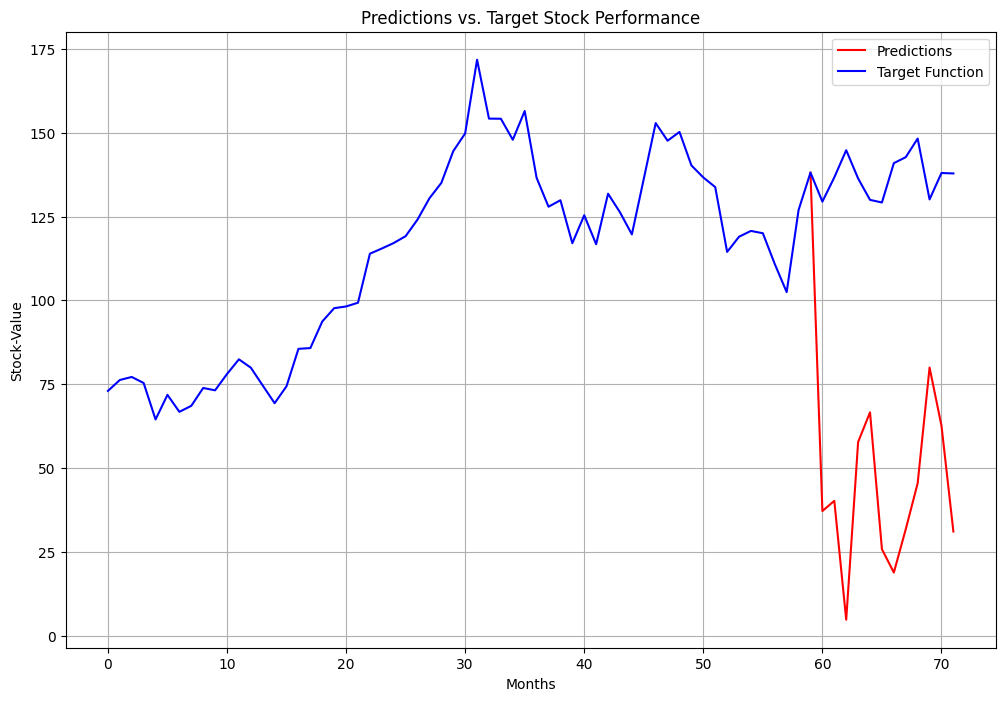

In [14]:
# Path to the used RAPModel
model_smoothL1loss = "./RAPModel/trained_model_aux-false_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_np = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_np)

# Prepare the comparison Date
target = [4.692009405211874e-06, 5.466743387201781e-06, 5.812687703220634e-06, 5.927919220900933e-06, 7.275632459163935e-06,6.985509247783324e-06, 8.063849849977355e-06, 6.360893276057977e-06, 7.184651099125486e-06,7.875696920662246e-06, 8.84750002906436e-06, 1.1411723516192887e-05, 1.1101770401000976e-05, 1.0944987829674895e-05, 1.6658468160543358e-05, 1.5032200668797349e-05, 1.7603364795323754e-05, 4.376864223429129e-06, 2.8367622599542556e-06, 6.498769022826742e-06, 4.853902082922962e-06, 7.505735482398254e-06, 4.944066206614177e-06, 3.6785550803029167e-06, 4.133710860364404e-06, 5.1510673552635585e-06, 5.050576582253829e-06, 5.094194849867579e-06, 5.809375015756091e-06, 4.970303572532357e-06, 5.479099463806013e-06, 6.977465170659404e-06, 8.31664660473343e-06, 7.3747864609029275e-06, 8.298825521929363e-06, 1.3295962234604047e-05, 1.884561542645251e-05, 3.364200830302844e-05, 1.9367176485452787e-05, 3.9407739093408034e-05, 3.980081951807416e-05, 5.086419265514365e-05, 7.414932787502197e-05, 8.37638639889744e-05, 0.0001295208373627105, 0.000126128175523546, 0.0003575585080866228, 0.00022620583019037358, 0.0001963656556372549, 0.0002709824124396135, 0.00046717195429353634, 0.000580613480673896, 0.0009214269788560851, 0.0011595767283300211, 0.0010815993688439811, 0.0014036561843247444, 0.0012193992455275804, 0.0025188592331247695, 0.01061036614338507, 0.01312552014182201, 0.01503394965372296, 0.017354364304315476, 0.016453505944279002, 0.018329071288595525, 0.016920466273811382, 0.01702354838900635, 0.01637107714832892, 0.015556659956418879, 0.015108747247887811, 0.01421452874730981, 0.014938964315570494, 0.015393059843423014]
target_tensor = torch.tensor(target, device=predictions.device)
target_tensor = target_tensor.unsqueeze(0)

# Denormalize the target data
norm_target_np = target_tensor.cpu().detach().numpy()
denorm_target_np = historical_scaler.inverse_transform(norm_target_np)

# Plot the data
# plot_single_function(denorm_predictions_np)
# plot_single_function(denorm_target_np)
plot_comparison_function(denorm_predictions_np, denorm_target_np)

## Comparison with unknown Data

We compare the model with unknown Data, to see how much sense the predictions make and how accurate it is.

### Model with Autoregressive Input enabled + CustomLoss ( 10 Epochs )


Retrieved tickers:  [array(['JZ', 'NXTT', 'QFIN', 'QSG', 'WAFU', 'EDU', 'CNET', 'ZH', 'TAOP',
       'YXT'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_outp

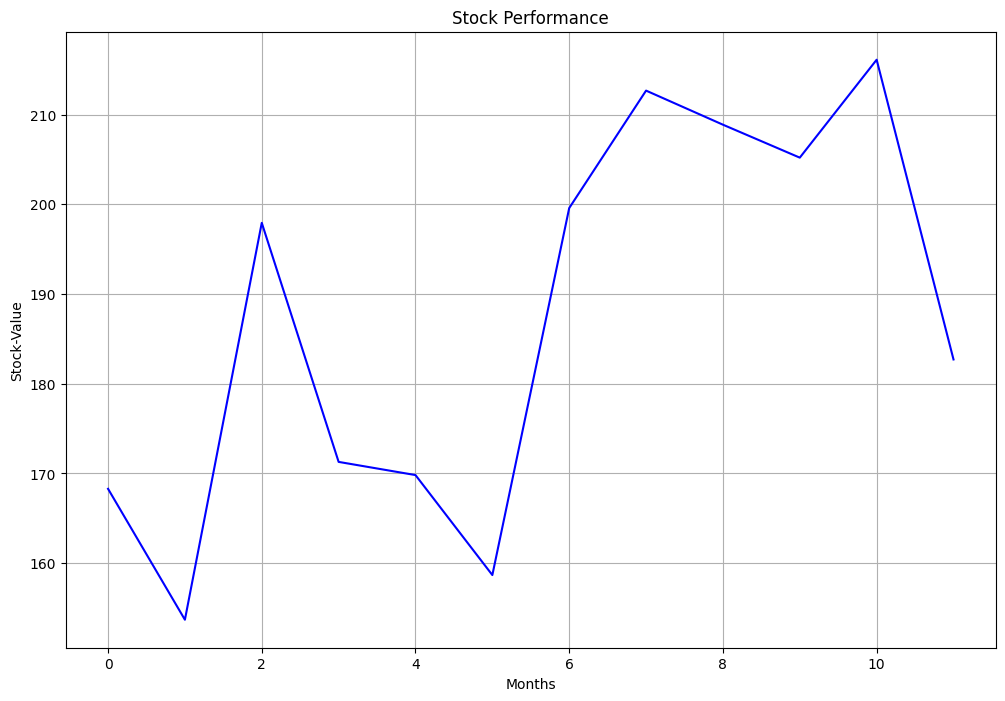

In [15]:
# Path to the used RAPModel
model_aux_customloss = "./RAPModel/trained_model_aux-true_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Jinxin Technology Holding Company operates as a digital content service provider that creates and develops digital self-learning contents and leisure reading materials in the People’s Republic of China. The company offers digital version of mainstream textbooks used in primary schools and middle schools; and digital textbooks in Chinese and English subjects used in K-9 schools. It distributes digital and integrated educational contents primarily through Namibox, a learning app; telecom and broadcast operators; and third-party devices. Jinxin Technology Holding Company was founded in 2014 and is based in Shanghai, the People’s Republic of China."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_customloss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_customloss)

# Plot the data
plot_single_function(denorm_predictions_aux_customloss)

### Model with Autoregressive Input enabled + CustomLoss ( 20 Epochs )

Retrieved tickers:  [array(['JZ', 'NXTT', 'QFIN', 'QSG', 'WAFU', 'EDU', 'CNET', 'ZH', 'TAOP',
       'YXT'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_outp

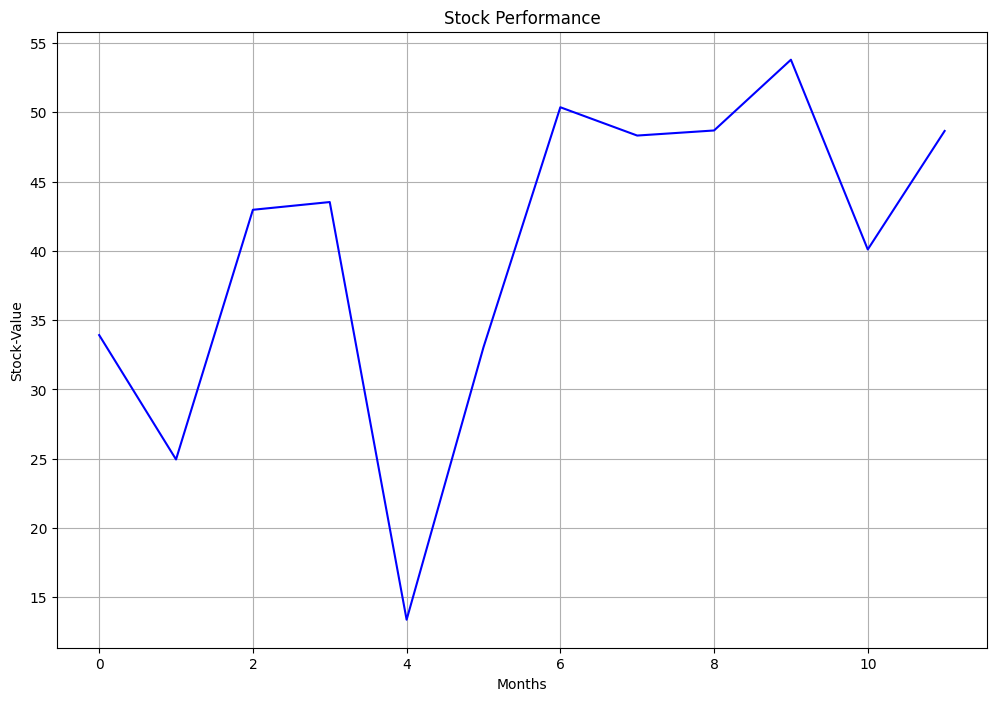

In [16]:
# Path to the used RAPModel
model_aux_customloss_20E = "./RAPModel/trained_model_aux-true_CustomLoss_20E.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss_20E, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Jinxin Technology Holding Company operates as a digital content service provider that creates and develops digital self-learning contents and leisure reading materials in the People’s Republic of China. The company offers digital version of mainstream textbooks used in primary schools and middle schools; and digital textbooks in Chinese and English subjects used in K-9 schools. It distributes digital and integrated educational contents primarily through Namibox, a learning app; telecom and broadcast operators; and third-party devices. Jinxin Technology Holding Company was founded in 2014 and is based in Shanghai, the People’s Republic of China."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_customloss_20E = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_customloss_20E)

# Plot the data
plot_single_function(denorm_predictions_aux_customloss_20E)

### Model with Autoregressive Input enabled + SmoothL1Loss


Retrieved tickers:  [array(['ALSA', 'AQU', 'AQUNU', 'PRLH', 'QETA', 'CMCA', 'GPATU', 'GPAT',
       'CFFS', 'PORT'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), histori

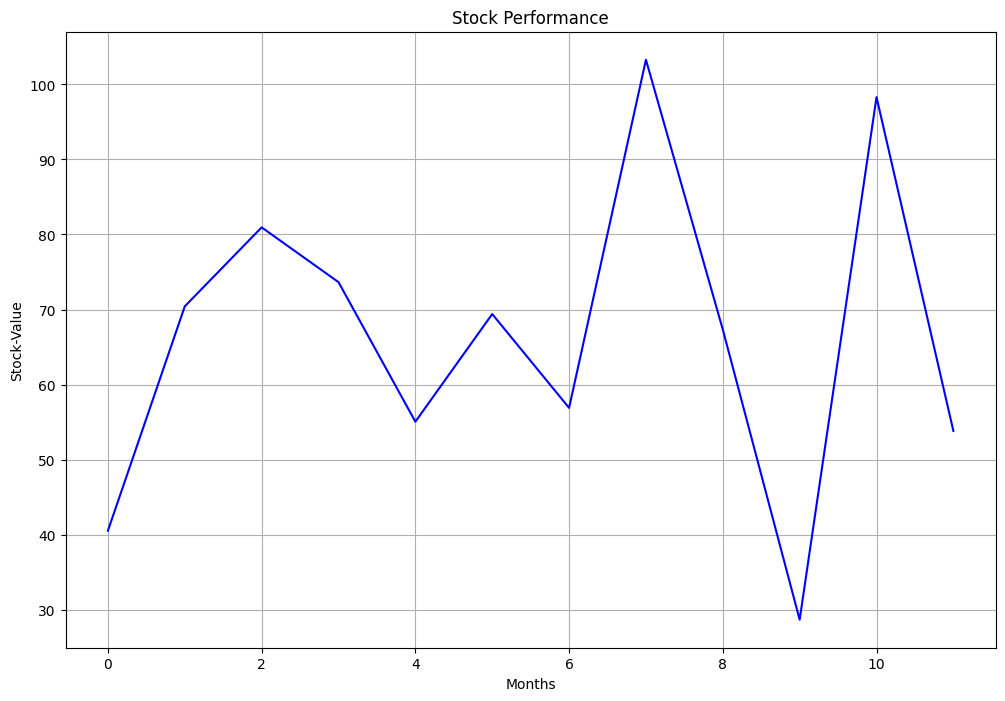

In [17]:
# Path to the used RAPModel
model_aux_smoothL1loss = "./RAPModel/trained_model_aux-true_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Jackson Acquisition Company II focuses on effecting a merger, share exchange, asset acquisition, share purchase, reorganization, or similar business combination with one or more businesses. It intends to focus its search for a target business in the healthcare services and healthcare technology sector. The company was incorporated in 2024 and is based in Alpharetta, Georgia."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_smoothl1loss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_smoothl1loss)

# Plot the data
plot_single_function(denorm_predictions_aux_smoothl1loss)


### Model with Autoregressive Input disabled + CustomLoss


Retrieved tickers:  [array(['ALSA', 'AQU', 'AQUNU', 'PRLH', 'QETA', 'CMCA', 'GPATU', 'GPAT',
       'CFFS', 'PORT'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), histori

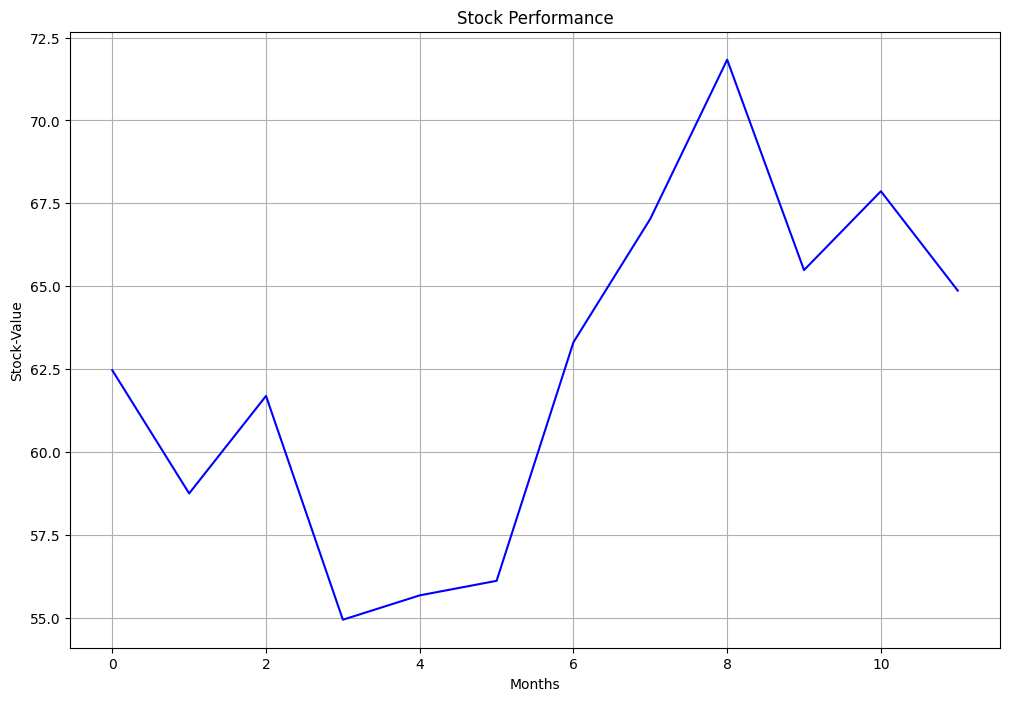

In [18]:
# Path to the used RAPModel
model_customloss = "./RAPModel/trained_model_aux-false_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Jackson Acquisition Company II focuses on effecting a merger, share exchange, asset acquisition, share purchase, reorganization, or similar business combination with one or more businesses. It intends to focus its search for a target business in the healthcare services and healthcare technology sector. The company was incorporated in 2024 and is based in Alpharetta, Georgia."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_customloss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_customloss)

# Plot the data
plot_single_function(denorm_predictions_customloss)


### Model with Autoregressive Input disabled + SmoothL1Loss


Retrieved tickers:  [array(['ALSA', 'AQU', 'AQUNU', 'PRLH', 'QETA', 'CMCA', 'GPATU', 'GPAT',
       'CFFS', 'PORT'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), histori

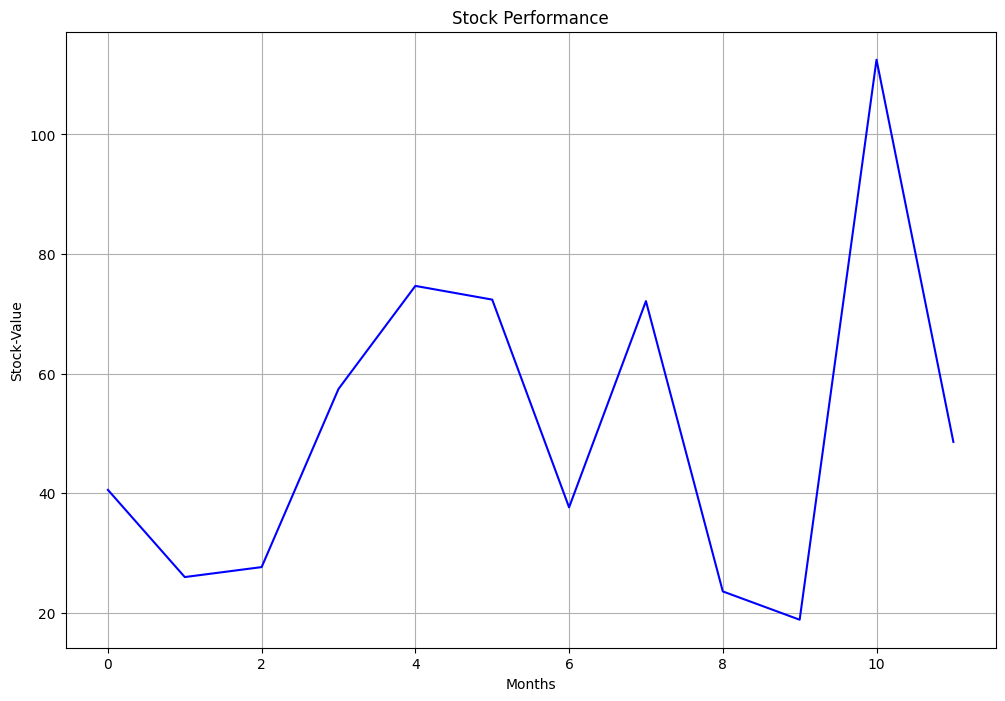

In [19]:
# Path to the used RAPModel
model_smoothL1loss = "./RAPModel/trained_model_aux-false_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["Jackson Acquisition Company II focuses on effecting a merger, share exchange, asset acquisition, share purchase, reorganization, or similar business combination with one or more businesses. It intends to focus its search for a target business in the healthcare services and healthcare technology sector. The company was incorporated in 2024 and is based in Alpharetta, Georgia."],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_smoothl1loss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_smoothl1loss)

# Plot the data
plot_single_function(denorm_predictions_smoothl1loss)


### Plot all the predictions to make a comparison

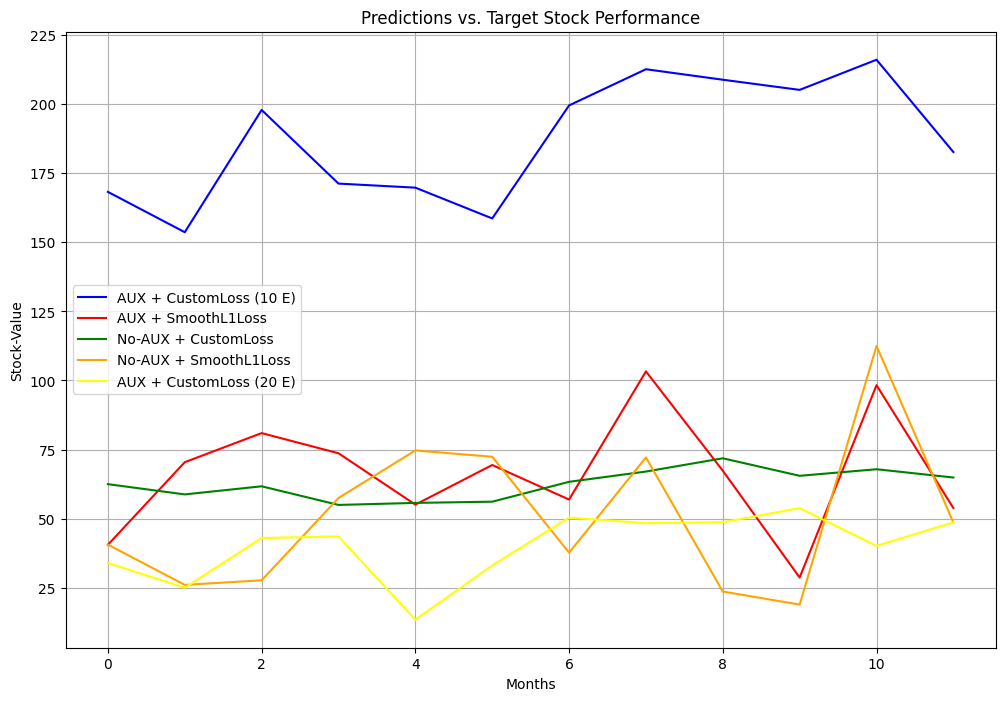

In [21]:
plot_comparison_function4(denorm_predictions_aux_customloss, denorm_predictions_aux_smoothl1loss, denorm_predictions_customloss, denorm_predictions_smoothl1loss, denorm_predictions_aux_customloss_20E)

## Comparison with Data that makes no sense

We compare the model with Data  that makes no sense, to see if the model detects it and outputs 0.


### Model with Autoregressive Input enabled + CustomLoss ( 10 Epochs )

Retrieved tickers:  [array(['BRFS', 'SKM', 'TLK', 'HTHT', 'RVTY', 'YY', 'FUTU', 'JAMF', 'YALA',
       'TAK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_ou

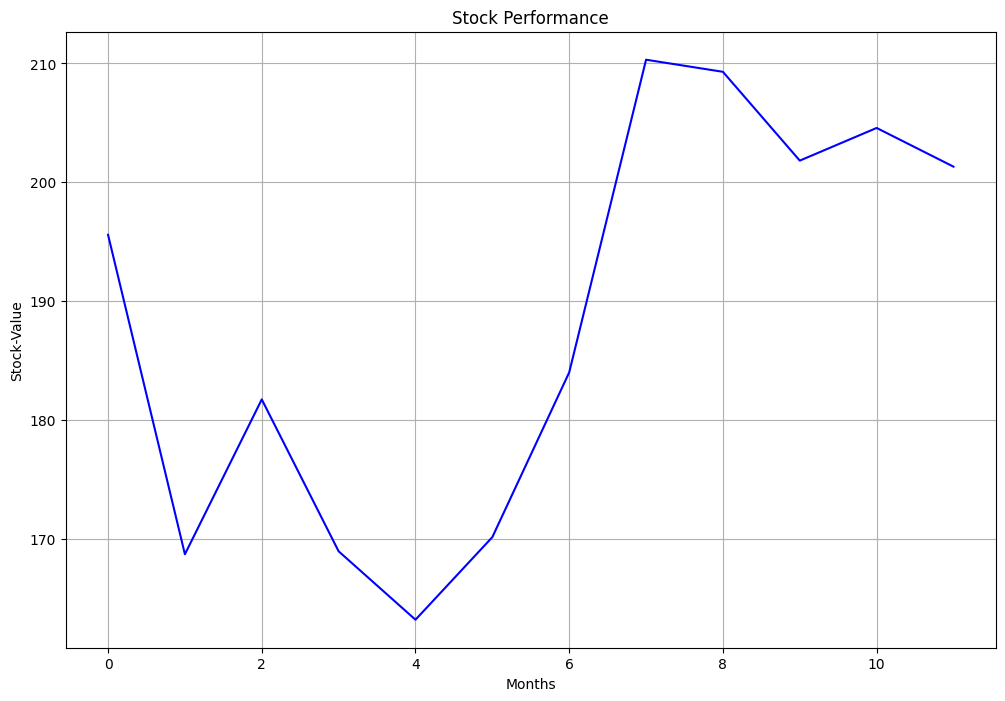

In [13]:
# Path to the used RAPModel
model_aux_customloss = "./RAPModel/trained_model_aux-true_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["NmmGOGIEdGbhVfWrdTHCrco nYvURKFmBCczEtMnfhyAKLjE RrVSnrOyOTfTbuMSxbycTxHiykBpRMTBIwvaEcoDxnvviQKLfRcxL YmfZoFfUrXKWteXuTNdvfFBoOgepIorl JYqIRljhuVJzktpgoeGpXUKILmxLkyOznvwAzrgdAvbypxprnToSDZdvvOfNDunSPoxtqFFndvOeZZPggCMtDUDICsfpdwNEcIuLcVbDqaQpgCCUMkcNQHSGUTp fQdEGoclUSPmq VKsGlgSj WAYjtQlKBOppJliGuVilt"],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_customloss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_customloss)

# Plot the data
plot_single_function(denorm_predictions_aux_customloss)

### Model with Autoregressive Input enabled + CustomLoss ( 20 Epochs )

Retrieved tickers:  [array(['BRFS', 'SKM', 'TLK', 'HTHT', 'RVTY', 'YY', 'FUTU', 'JAMF', 'YALA',
       'TAK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_ou

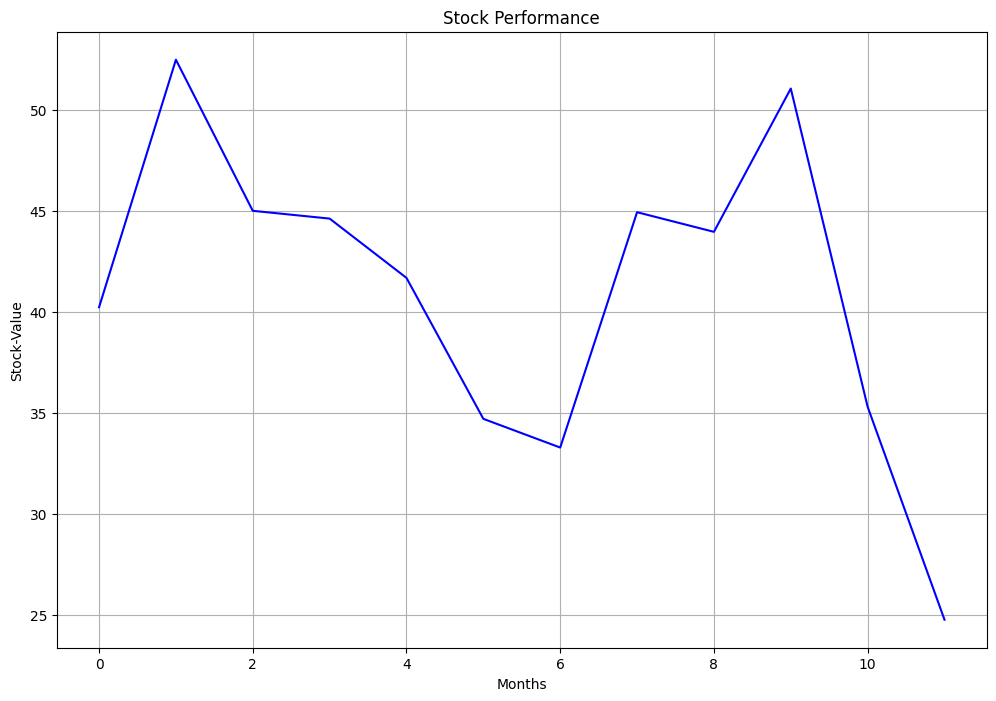

In [22]:
# Path to the used RAPModel
model_aux_customloss_20E = "./RAPModel/trained_model_aux-true_CustomLoss_20E.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_customloss_20E, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["NmmGOGIEdGbhVfWrdTHCrco nYvURKFmBCczEtMnfhyAKLjE RrVSnrOyOTfTbuMSxbycTxHiykBpRMTBIwvaEcoDxnvviQKLfRcxL YmfZoFfUrXKWteXuTNdvfFBoOgepIorl JYqIRljhuVJzktpgoeGpXUKILmxLkyOznvwAzrgdAvbypxprnToSDZdvvOfNDunSPoxtqFFndvOeZZPggCMtDUDICsfpdwNEcIuLcVbDqaQpgCCUMkcNQHSGUTp fQdEGoclUSPmq VKsGlgSj WAYjtQlKBOppJliGuVilt"],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_customloss_20E = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_customloss_20E)

# Plot the data
plot_single_function(denorm_predictions_aux_customloss_20E)

### Model with Autoregressive Input enabled + SmoothL1Loss

Retrieved tickers:  [array(['BRFS', 'SKM', 'TLK', 'HTHT', 'RVTY', 'YY', 'FUTU', 'JAMF', 'YALA',
       'TAK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_ou

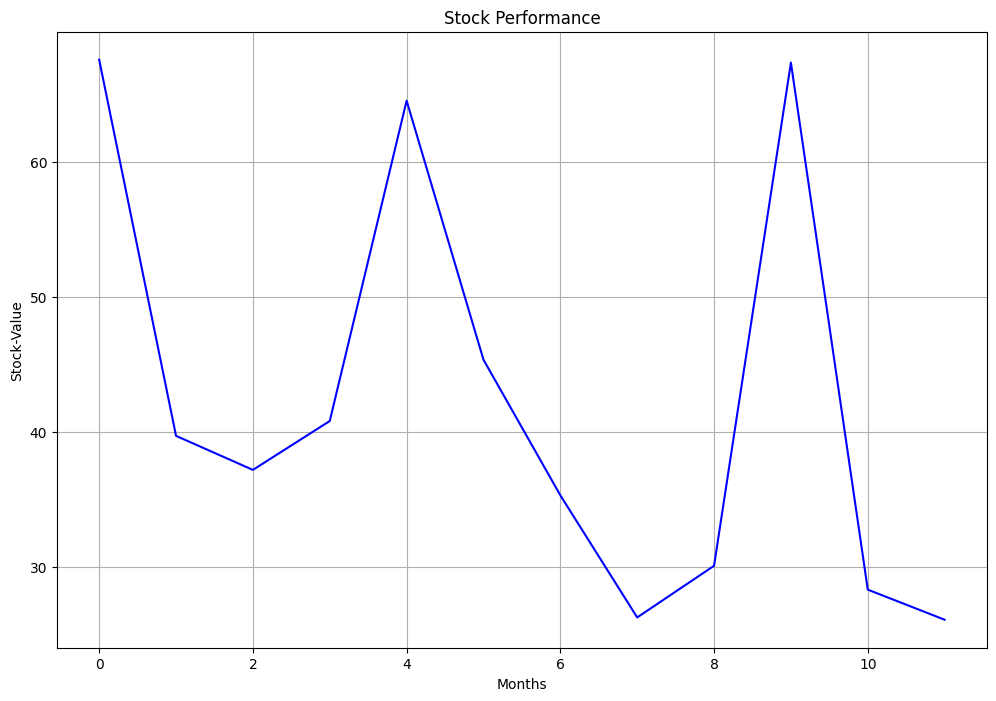

In [14]:
# Path to the used RAPModel
model_aux_smoothL1loss = "./RAPModel/trained_model_aux-true_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_aux_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["NmmGOGIEdGbhVfWrdTHCrco nYvURKFmBCczEtMnfhyAKLjE RrVSnrOyOTfTbuMSxbycTxHiykBpRMTBIwvaEcoDxnvviQKLfRcxL YmfZoFfUrXKWteXuTNdvfFBoOgepIorl JYqIRljhuVJzktpgoeGpXUKILmxLkyOznvwAzrgdAvbypxprnToSDZdvvOfNDunSPoxtqFFndvOeZZPggCMtDUDICsfpdwNEcIuLcVbDqaQpgCCUMkcNQHSGUTp fQdEGoclUSPmq VKsGlgSj WAYjtQlKBOppJliGuVilt"],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_aux_smoothl1loss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_aux_smoothl1loss)

# Plot the data
plot_single_function(denorm_predictions_aux_smoothl1loss)


### Model with Autoregressive Input disabled + CustomLoss

Retrieved tickers:  [array(['BRFS', 'SKM', 'TLK', 'HTHT', 'RVTY', 'YY', 'FUTU', 'JAMF', 'YALA',
       'TAK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_ou

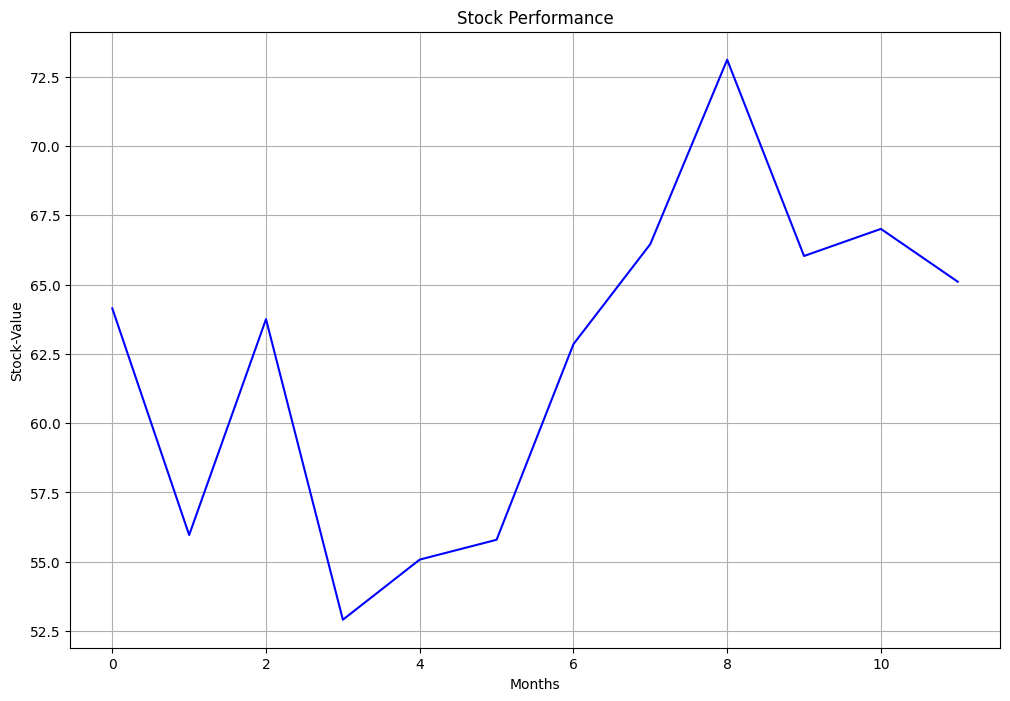

In [15]:
# Path to the used RAPModel
model_customloss = "./RAPModel/trained_model_aux-false_CustomLoss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_customloss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["NmmGOGIEdGbhVfWrdTHCrco nYvURKFmBCczEtMnfhyAKLjE RrVSnrOyOTfTbuMSxbycTxHiykBpRMTBIwvaEcoDxnvviQKLfRcxL YmfZoFfUrXKWteXuTNdvfFBoOgepIorl JYqIRljhuVJzktpgoeGpXUKILmxLkyOznvwAzrgdAvbypxprnToSDZdvvOfNDunSPoxtqFFndvOeZZPggCMtDUDICsfpdwNEcIuLcVbDqaQpgCCUMkcNQHSGUTp fQdEGoclUSPmq VKsGlgSj WAYjtQlKBOppJliGuVilt"],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_customloss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_customloss)

# Plot the data
plot_single_function(denorm_predictions_customloss)


### Model with Autoregressive Input disabled + SmoothL1Loss

Retrieved tickers:  [array(['BRFS', 'SKM', 'TLK', 'HTHT', 'RVTY', 'YY', 'FUTU', 'JAMF', 'YALA',
       'TAK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_ou

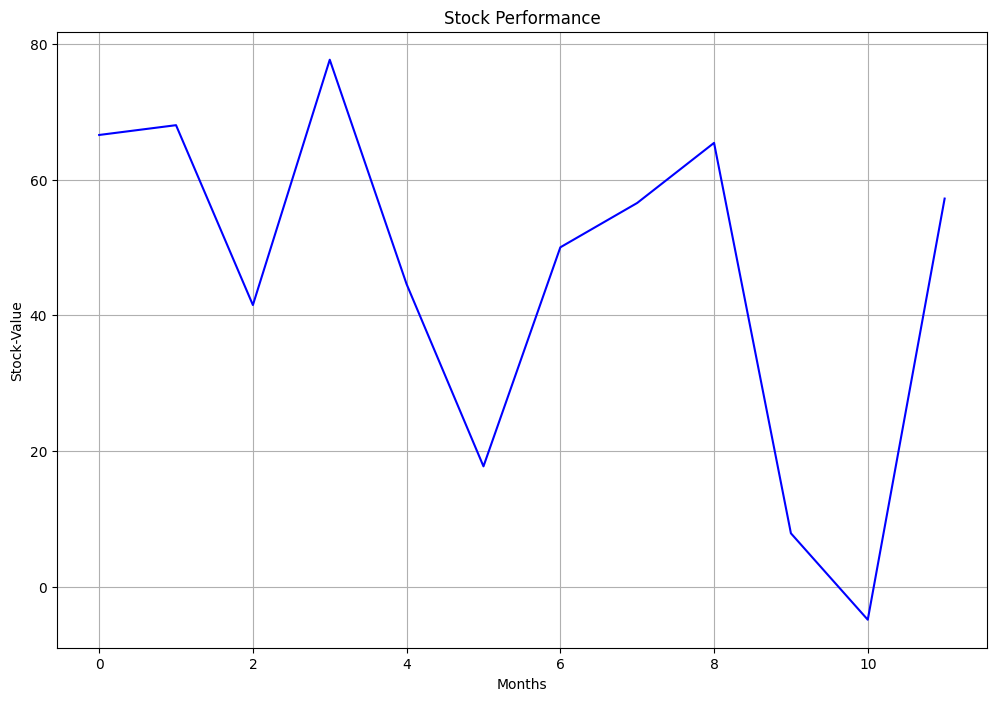

In [16]:
# Path to the used RAPModel
model_smoothL1loss = "./RAPModel/trained_model_aux-false_SmoothL1Loss.pth"

# Load the model on the device where you want to use it
model = RetrievalAugmentedPredictionModel(ret_sys=retrieval_system, retrieval_number=retrieval_num, forecast_steps=forecast_steps_num)
model.load_state_dict(torch.load(model_smoothL1loss, map_location=device, weights_only=False))

# Make a prediction to an already known company
predictions = model(
    ideas=["NmmGOGIEdGbhVfWrdTHCrco nYvURKFmBCczEtMnfhyAKLjE RrVSnrOyOTfTbuMSxbycTxHiykBpRMTBIwvaEcoDxnvviQKLfRcxL YmfZoFfUrXKWteXuTNdvfFBoOgepIorl JYqIRljhuVJzktpgoeGpXUKILmxLkyOznvwAzrgdAvbypxprnToSDZdvvOfNDunSPoxtqFFndvOeZZPggCMtDUDICsfpdwNEcIuLcVbDqaQpgCCUMkcNQHSGUTp fQdEGoclUSPmq VKsGlgSj WAYjtQlKBOppJliGuVilt"],
    dataset=dataset,
    use_auxiliary_inputs=False
)

print(" ==== Normalized Prediction from our RAPModel ===")
print(predictions)

# denormalize the predictions
norm_predictions = torch.zeros(1, 72)
norm_predictions[0, 60:72] = predictions
norm_predictions_np = norm_predictions.cpu().detach().numpy()
denorm_predictions_np = historical_scaler.inverse_transform(norm_predictions_np)
print(denorm_predictions_np)
print(len(denorm_predictions_np))
denorm_predictions_smoothl1loss = denorm_predictions_np[:, 60:72]

print(" ==== Denormalized Prediction from our RAPModel ===")
print(denorm_predictions_smoothl1loss)

# Plot the data
plot_single_function(denorm_predictions_smoothl1loss)

### Plot all the predictions to make a comparison


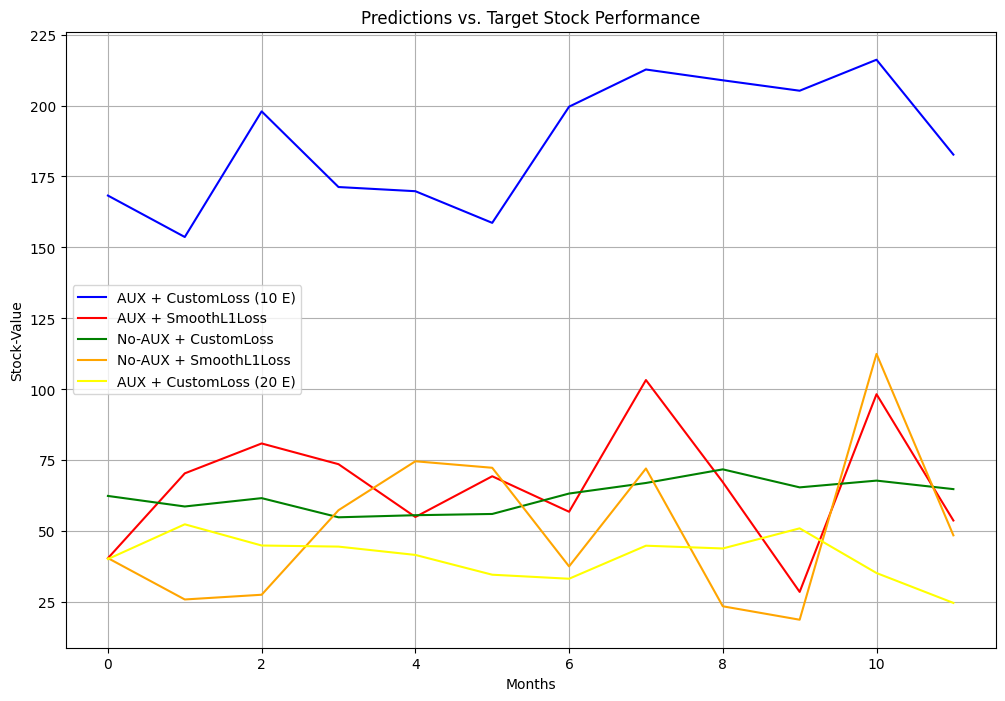

In [23]:
plot_comparison_function4(denorm_predictions_aux_customloss, denorm_predictions_aux_smoothl1loss, denorm_predictions_customloss, denorm_predictions_smoothl1loss, denorm_predictions_aux_customloss_20E)